This notebook is meant as a demonstration to show how exactly LLMs and Transformers work and why they are so effective. We will start off assuming that you have some basic knowledge about how neural networks work in PyTorch. Below we will create the model architecture using some prebuilt layers from the PyTorch package. After that we will demonstrate how exactly those layers are constructed. Then we will train the model and demonstrate that it learned something.

For the below model instead of using words we will just use numbers to try to predict the next number in a sequence of numbers. Under the hood this is what LLMs do as they map each word to a series of numbers because the models can only understand numbers and not words.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class SmallLLM(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, num_layers):
        super(SmallLLM, self).__init__()
        
        # This is an interesting embedding layer we will be digging deeper into later in this tutorial
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        # This layer is also likely new and is the fundamental strength of the new series of LLMs coming out
        # The transformer architecture beats the previously dominant RNNs and other NLP models
        self.transformer = nn.Transformer(embed_size, num_heads, num_layers)
        self.fc = nn.Linear(embed_size, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x, x)
        x = self.fc(x)
        return x


# Since we are working with 10 numbers (0-9) our vocab size will be 10
vocab_size = 10  

# You can treat these as hyper-parameters of our model
embed_size = 32  
num_heads = 2    
num_layers = 2 

# Initialize model, loss, and optimizer
model = SmallLLM(vocab_size, embed_size, num_heads, num_layers)

# We use CrossEntropyLoss because we are in essence looking to classify the next token in the series
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Show the model architecture
model

SmallLLM(
  (embedding): Embedding(10, 32)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=32, bias=True)
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn

Now let's dig into what both of those layers are really doing. First we can look into the embedding layer. Please note that the embdedding layer expects an integer input and if you are curious how we get from words -> integers as our model inputs then please look at the tokenization notebook.

Below we define an embedding layer. Essentially this layer maps integeres (0-vocab_size) and produces a embedding size dimensional output, in this case 3. The idea here is that our model will be able to learn the relationship between different integers and a multi-dimensional continuous output which feeds into the transformer layer.

In [7]:

# Here we define an embedding layer with a vocab size of 5 and an dimensions of embeddings of 3
embedding = nn.Embedding(5, 3)

# This will be the input to our embedding layer, feel free to mess around with it
input_indices = torch.LongTensor([1, 2, 4, 0])

# Pass in our input vocab
embedded = embedding(input_indices)

# Display our result which is essentially random at this point
embedded

tensor([[ 0.9070,  0.9123, -0.1542],
        [-1.0586,  0.0818, -1.3950],
        [-1.2679, -1.3518, -1.0793],
        [-0.8483,  1.1451, -0.5357]], grad_fn=<EmbeddingBackward0>)

To summarize, the purpose of the embedding layer is to turn our vocabulary integers into a multidimensional continuous output. This helps us extract the maximum amount of information from the vocabulary inputs.

Now let's look into the transformer layer.

Now let's put it all together and train our numerical sequence predictor model

In [9]:
import numpy as np

# Generate some dummy data
# Sequences are arrays from 0 to 9 (our vocab)
# For each sequence, the target is the sequence shifted by one position
sequences = np.array([[i for i in range(10)] for _ in range(100)])
targets = np.array([[i for i in range(1, 10)] + [0] for _ in range(100)])

# Convert to PyTorch tensors
sequences = torch.LongTensor(sequences)
targets = torch.LongTensor(targets)

# Create DataLoader
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(sequences, targets)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Training loop
epochs = 50

for epoch in range(epochs):
    for batch_seq, batch_target in dataloader:
        # Forward pass
        outputs = model(batch_seq)
        
        # Reshape for loss calculation
        outputs = outputs.view(-1, vocab_size)
        batch_target = batch_target.view(-1)
        
        # Calculate loss
        loss = criterion(outputs, batch_target)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss every epoch
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/50], Loss: 0.0119
Epoch [2/50], Loss: 0.0109
Epoch [3/50], Loss: 0.0103
Epoch [4/50], Loss: 0.0096
Epoch [5/50], Loss: 0.0089
Epoch [6/50], Loss: 0.0083
Epoch [7/50], Loss: 0.0080
Epoch [8/50], Loss: 0.0074
Epoch [9/50], Loss: 0.0068
Epoch [10/50], Loss: 0.0065
Epoch [11/50], Loss: 0.0063
Epoch [12/50], Loss: 0.0059
Epoch [13/50], Loss: 0.0056
Epoch [14/50], Loss: 0.0052
Epoch [15/50], Loss: 0.0051
Epoch [16/50], Loss: 0.0047
Epoch [17/50], Loss: 0.0045
Epoch [18/50], Loss: 0.0043
Epoch [19/50], Loss: 0.0042
Epoch [20/50], Loss: 0.0039
Epoch [21/50], Loss: 0.0039
Epoch [22/50], Loss: 0.0038
Epoch [23/50], Loss: 0.0035
Epoch [24/50], Loss: 0.0034
Epoch [25/50], Loss: 0.0033
Epoch [26/50], Loss: 0.0031
Epoch [27/50], Loss: 0.0030
Epoch [28/50], Loss: 0.0029
Epoch [29/50], Loss: 0.0028
Epoch [30/50], Loss: 0.0027
Epoch [31/50], Loss: 0.0026
Epoch [32/50], Loss: 0.0025
Epoch [33/50], Loss: 0.0025
Epoch [34/50], Loss: 0.0024
Epoch [35/50], Loss: 0.0023
Epoch [36/50], Loss: 0.0021
E

Now we can use our trained model to make some predictions

In [11]:
# Fixing the generate_numbers function to have correct input dimensions
def generate_numbers(model, start_sequence, length):
    generated_sequence = start_sequence.copy()
    
    for _ in range(length):
        input_sequence = torch.LongTensor([generated_sequence[-10:]]).transpose(0, 1)
        output = model(input_sequence)
        next_number = torch.argmax(output[0, -1]).item()
        generated_sequence.append(next_number)
    
    return generated_sequence

# Generate a sequence starting with [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
generated_sequence = generate_numbers(model, [i for i in range(10)], 20)
generated_sequence


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 7,
 3,
 7,
 7,
 8,
 8,
 9,
 9,
 9,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2]

Now just as a short example we can switch from a numerical sequence predictor to a word based model and see what the results are. This example will encorporate a lot of subjects detailed in this notebook and in the tokenization notebook.

In [54]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.tokenize import word_tokenize


import nltk
nltk.download('state_union')
from nltk.corpus import state_union

# Fetch sentences from the reuters dataset, we use the state of the union dataset
# Maybe our LLM will be speaking like a politician
sentences = [' '.join(sent) for sent in state_union.sents()[:1000]]


# Tokenize and build vocabulary
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]
flat_tokens = [token for sublist in tokenized_sentences for token in sublist]
vocab_counter = Counter(flat_tokens)

# Build the integer mapping between the words and their corresponding integer
vocab = {word: i+2 for i, (word, _) in enumerate(vocab_counter.most_common())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1
vocab_size = len(vocab)

index_to_word = {i: word for word, i in vocab.items()}

# Encode with our new mapping between words and integers
encoded_sentences = [[vocab.get(token, vocab["<UNK>"]) for token in sentence] for sentence in tokenized_sentences]

# Generate sequences and targets which we will later make into training and testing sets
sequences = []
targets = []
sequence_length = 5 # Change this so that we will be able to make more complex sentences

for sentence in encoded_sentences:
    for i in range(len(sentence) - sequence_length + 1):
        sequences.append(sentence[i:i + sequence_length - 1])
        targets.append(sentence[i + 1:i + sequence_length])

# Training and validation split
split_idx = int(0.8 * len(sequences))
train_sequences, val_sequences = sequences[:split_idx], sequences[split_idx:]
train_targets, val_targets = targets[:split_idx], targets[split_idx:]

# Convert to PyTorch tensors which we will make dataloaders and then use in our training loop
train_sequences = torch.LongTensor(train_sequences)
train_targets = torch.LongTensor(train_targets)
val_sequences = torch.LongTensor(val_sequences)
val_targets = torch.LongTensor(val_targets)

# DataLoader
train_dataset = TensorDataset(train_sequences, train_targets)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = TensorDataset(val_sequences, val_targets)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Initialize model, criterion and the optimzer
model = SmallLLM(vocab_size, embed_size, num_heads, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
epochs = 25  # This will determine how long the model trains for
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_seq, batch_target in train_dataloader:
        outputs = model(batch_seq)
        outputs = outputs.view(-1, vocab_size)
        batch_target = batch_target.view(-1)
        loss = criterion(outputs, batch_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_seq, batch_target in val_dataloader:
            outputs = model(batch_seq)
            outputs = outputs.view(-1, vocab_size)
            batch_target = batch_target.view(-1)
            loss = criterion(outputs, batch_target)
            val_loss += loss.item()
    
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]

final_train_loss, final_val_loss # Print our final metrics

[nltk_data] Downloading package state_union to
[nltk_data]     /Users/zfara/nltk_data...
[nltk_data]   Package state_union is already up-to-date!


(5.871013979905776, 7.673558832058651)

If you look below we didn't really improve on our validation set. This is probably because we used a super small model, a short training time and a relatively complex corpus. However, we still should be able to

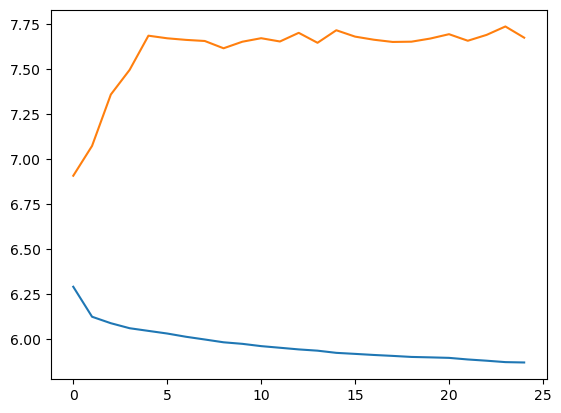

In [55]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)

In [72]:
def generate_text(model, initial_sequence, length, vocab, index_to_word):
    model.eval()
    generated_sequence = initial_sequence.copy()
    
    for _ in range(length):
        input_sequence = torch.LongTensor([generated_sequence[-5:]]).to('cuda' if torch.cuda.is_available() else 'cpu')
        with torch.no_grad():
            output = model(input_sequence)
        next_word_idx = torch.argmax(output[0, -1]).item()
        
        generated_sequence.append(next_word_idx)
    
    generated_sentence = ' '.join([index_to_word[idx] for idx in generated_sequence])
    return generated_sentence

# Example usage
initial_sequence = [vocab.get(word, vocab["<UNK>"]) for word in ["how","can"]]
generated_sentence = generate_text(model, initial_sequence, 4, vocab, index_to_word)
print(generated_sentence)

how can be been the congress
